In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import os
import glob
import json
import keras
from keras.utils import np_utils
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from scipy.ndimage.filters import *
from csbdeep.utils import normalize 
from keras.callbacks import EarlyStopping

C:\Users\myerslab\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Images are in format (Z,Y,X)

In [17]:
folder = "D:\\Data\\2018-08-24-12-42-59-86-RandomZernike"

In [18]:
def onehot_encode(arr): 
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

In [19]:
# Normalization of the entrire stack
def entireStackNormalization(stackImgData): 
    # Mean and std of entire stack
    if False:
        mean = np.mean(stackImgData)
        std = np.std(stackImgData)
        normalizedStackImgData = (stackImgData - mean) / std
        return normalizedStackImgData
    else:
        return normalize(stackImgData,2,99.8,clip=False)

In [20]:
# Label map
classes = ["Oblique Astigmation","Vertical Astigmation"]
onehot = onehot_encode(classes)

for i,c in enumerate(classes):
    print('%10s → [%d,%d]' % (c, onehot[i,0], onehot[i,1]))

Oblique Astigmation → [1,0]
Vertical Astigmation → [0,1]


In [21]:
# Sorting files
files = glob.glob(folder+ "\\*.json")
timepoint = [int(f[f.rfind('_')+1:f.rfind('.')]) for f in files]
files = [f for _,f in sorted(zip(timepoint,files))]

In [22]:
files

['D:\\Data\\2018-08-24-12-42-59-86-RandomZernike\\ALPAO_BIL118_zernike_factors_4.json',
 'D:\\Data\\2018-08-24-12-42-59-86-RandomZernike\\ALPAO_BIL118_zernike_factors_9.json',
 'D:\\Data\\2018-08-24-12-42-59-86-RandomZernike\\ALPAO_BIL118_zernike_factors_14.json',
 'D:\\Data\\2018-08-24-12-42-59-86-RandomZernike\\ALPAO_BIL118_zernike_factors_19.json',
 'D:\\Data\\2018-08-24-12-42-59-86-RandomZernike\\ALPAO_BIL118_zernike_factors_24.json',
 'D:\\Data\\2018-08-24-12-42-59-86-RandomZernike\\ALPAO_BIL118_zernike_factors_29.json',
 'D:\\Data\\2018-08-24-12-42-59-86-RandomZernike\\ALPAO_BIL118_zernike_factors_34.json',
 'D:\\Data\\2018-08-24-12-42-59-86-RandomZernike\\ALPAO_BIL118_zernike_factors_39.json',
 'D:\\Data\\2018-08-24-12-42-59-86-RandomZernike\\ALPAO_BIL118_zernike_factors_44.json',
 'D:\\Data\\2018-08-24-12-42-59-86-RandomZernike\\ALPAO_BIL118_zernike_factors_49.json',
 'D:\\Data\\2018-08-24-12-42-59-86-RandomZernike\\ALPAO_BIL118_zernike_factors_54.json',
 'D:\\Data\\2018-08-24-

In [23]:
# Loading mirror modes
modes = np.array([json.load(open(f)) for f in files])
modes = modes[:,:,4:6]
modes = np.reshape(modes,(modes.shape[0],modes.shape[-1]))
#Y = np.ceil(np.abs(modes))
#Y = modes
#Y = np.concatenate((modes,modes,modes,modes,modes,modes,modes,modes))

In [27]:
# Loading ImageData
imageFiles = glob.glob(folder+ "\\stacks\\Beads\\*" )
imageData = [None] * len(imageFiles)
Y = np.zeros((len(imageData),2))
for i,f in enumerate(imageFiles):
    counter = int(f[f.rfind("\\")+1:f.rfind("_")])
    Y[i] = modes[counter]
    imageData[i] = tifffile.imread(f)
imageData = np.array(imageData)

In [28]:
# Creating the input dataset
X = np.array([entireStackNormalization(i) for i in imageData])

In [29]:
imageData.shape

(8928, 80, 64, 64)

In [30]:
X.shape

(8928, 80, 64, 64)

In [31]:
# data size for conv layer
X = np.expand_dims(X,-1)
print(X.shape,Y.shape)

(8928, 80, 64, 64, 1) (8928, 2)


In [48]:
# Loading testing data
test_folder = "D:\\Data\\2018-08-24-12-35-09-92-RandomZernike"
# Sorting files
test_files = glob.glob(test_folder+ "\\*.json")
test_timepoint = [int(f[f.rfind('_')+1:f.rfind('.')]) for f in test_files]
test_files = [f for _,f in sorted(zip(test_timepoint,test_files))]

# Loading mirror modes
test_modes = np.array([json.load(open(f)) for f in test_files])
test_modes = test_modes[:,:,4:6]
test_modes = np.reshape(test_modes,(test_modes.shape[0],test_modes.shape[-1]))

# Loading ImageData
test_imageFiles = glob.glob(test_folder+ "\\stacks\\Beads\\*" )
test_imageData = [None] * len(test_imageFiles)
test_Y = np.zeros((len(test_imageData),2))
for i,f in enumerate(test_imageFiles):
    counter = int(f[f.rfind("\\")+1:f.rfind("_")])
    test_Y[i] = test_modes[counter]
    test_imageData[i] = tifffile.imread(f)
test_imageData = np.array(test_imageData)

test_X = np.array([entireStackNormalization(i) for i in test_imageData])
test_X = np.expand_dims(test_X,-1)


Xt,Xv = X,test_X
Yt,Yv = Y,test_Y

In [49]:
print(Xt.shape,Xv.shape)
print(Yt.shape,Yv.shape)

(8928, 80, 64, 64, 1) (57, 80, 64, 64, 1)
(8928, 2) (57, 2)


In [34]:
# CNN Model
def get_model():
    inp = Input(       name='X',     shape=Xt.shape[1:])    
    t   = Conv3D(64,   name='conv1', kernel_size=(3,3,3), activation='relu')(inp)
    t   = Conv3D(64,   name='conv2', kernel_size=(3,3,3), activation='relu')(t)
    t   = MaxPooling3D(name='pool1', pool_size=(2,2,2))(t)
    t   = Conv3D(64,   name='conv3', kernel_size=(3,3,3), activation='relu')(t)
    t   = Conv3D(64,   name='conv4', kernel_size=(3,3,3), activation='relu')(t)
    t   = MaxPooling3D(name='pool2', pool_size=(2,2,2))(t)
    t   = Conv3D(64,   name='conv5', kernel_size=(3,3,3), activation='relu')(t)
    t   = Conv3D(64,   name='conv6', kernel_size=(3,3,3), activation='relu')(t)
    t   = MaxPooling3D(name='pool3', pool_size=(2,2,2))(t)
    #t   = Conv3D(32,   name='conv7', kernel_size=(3,3,3), activation='relu')(t)
    #t   = Conv3D(32,   name='conv8', kernel_size=(3,3,3), activation='relu')(t)
    #t   = MaxPooling3D(name='pool4', pool_size=(2,2,2))(t)
    t   = Flatten(     name='flat')(t)
    t   = Dense(128,   name='dense1', activation='relu')(t)
    t   = Dense(128,   name='dense2', activation='relu')(t)
    oup = Dense(Yt.shape[1],    name='Y', activation='linear')(t)
    model = Model(inp,oup)
    model.compile(loss='mse', optimizer=Adam(1e-4))
    return model

In [35]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 80, 64, 64, 1)     0         
_________________________________________________________________
conv1 (Conv3D)               (None, 78, 62, 62, 64)    1792      
_________________________________________________________________
conv2 (Conv3D)               (None, 76, 60, 60, 64)    110656    
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 38, 30, 30, 64)    0         
_________________________________________________________________
conv3 (Conv3D)               (None, 36, 28, 28, 64)    110656    
_________________________________________________________________
conv4 (Conv3D)               (None, 34, 26, 26, 64)    110656    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 17, 13, 13, 64)    0         
__________

In [36]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
hist = model.fit(Xt,Yt,batch_size=5, epochs=30,validation_data=(Xv,Yv))

Train on 6696 samples, validate on 2232 samples
Epoch 1/30
6696/6696 [==============================] - 388s 58ms/step - loss: 4.4012e-04 - val_loss: 1.0188e-04
Epoch 2/30
6696/6696 [==============================] - 378s 56ms/step - loss: 7.6805e-05 - val_loss: 1.0266e-04
Epoch 3/30
6696/6696 [==============================] - 377s 56ms/step - loss: 5.1415e-05 - val_loss: 4.4564e-05
Epoch 4/30
6696/6696 [==============================] - 376s 56ms/step - loss: 4.0772e-05 - val_loss: 8.8354e-05
Epoch 5/30
6696/6696 [==============================] - 377s 56ms/step - loss: 3.6096e-05 - val_loss: 3.1907e-05
Epoch 6/30
6696/6696 [==============================] - 376s 56ms/step - loss: 3.1410e-05 - val_loss: 2.3611e-05
Epoch 7/30
6696/6696 [==============================] - 377s 56ms/step - loss: 2.6146e-05 - val_loss: 3.0504e-05
Epoch 8/30
6696/6696 [==============================] - 375s 56ms/step - loss: 2.3206e-05 - val_loss: 2.5062e-05
Epoch 9/30
6696/6696 [==========================

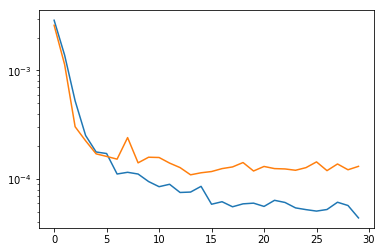

In [197]:
plt.figure(); plt.semilogy(hist.epoch,hist.history['loss'])
plt.plot(hist.epoch,hist.history['val_loss'])

In [198]:
testImage = tifffile.imread("D://Data//2018-08-24-13-17-42-13-RandomZernike//stacks//CheckImages/*.tif")

In [199]:
testImage = np.expand_dims(testImage,-1)

In [200]:
testImage = np.expand_dims(testImage,0)

In [201]:
testImage.shape

(1, 71, 64, 64, 1)

In [203]:
model.predict(entireStackNormalization(testImage))

array([[ 0.0729943 , -0.01379927]], dtype=float32)

In [184]:
Xv.shape
Yv.shape
P = model.predict(Xv)

In [185]:
P.shape

(328, 2)

In [186]:
Yv[:5]

array([[-0.001,  0.04 ],
       [ 0.028, -0.037],
       [-0.07 ,  0.042],
       [-0.035,  0.079],
       [-0.076, -0.057]])

In [187]:
P[:5]

array([[-0.0012948 ,  0.04664279],
       [ 0.03364392, -0.03870861],
       [-0.06949345,  0.04014431],
       [-0.03657097,  0.07063944],
       [-0.07234331, -0.03738775]], dtype=float32)

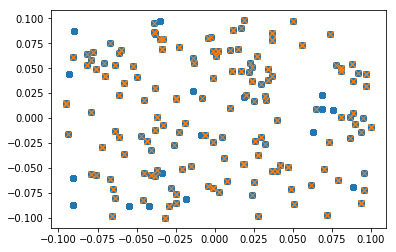

In [195]:
Y.shape
plt.plot(Yt[:,0],Yt[:,1],'o')
plt.plot(Yv[:,0],Yv[:,1],'x')

In [40]:
testImages = np.array([tifffile.imread(f) for f in glob.glob(folder+ "\\stacks\\CheckImages\\*" )])

In [41]:
testImages = np.expand_dims(testImages,-1)

In [42]:
testImages.shape

(57, 80, 64, 64, 1)

In [44]:
np.round(model.predict(testImages),3)

array([[ 0.027, -0.01 ],
       [-0.004,  0.035],
       [ 0.025,  0.056],
       [ 0.005,  0.038],
       [ 0.02 ,  0.051],
       [-0.071,  0.068],
       [ 0.005, -0.   ],
       [ 0.019, -0.019],
       [ 0.01 ,  0.009],
       [ 0.023,  0.046],
       [ 0.003,  0.009],
       [ 0.01 ,  0.029],
       [ 0.006,  0.027],
       [ 0.008, -0.01 ],
       [ 0.002, -0.016],
       [-0.011,  0.022],
       [ 0.014,  0.017],
       [-0.027, -0.013],
       [ 0.022,  0.031],
       [ 0.033,  0.015],
       [ 0.006,  0.016],
       [ 0.042,  0.005],
       [ 0.012,  0.028],
       [ 0.007,  0.046],
       [ 0.022,  0.001],
       [-0.037,  0.095],
       [ 0.018,  0.005],
       [ 0.013, -0.012],
       [ 0.002,  0.007],
       [ 0.026,  0.032],
       [ 0.007, -0.032],
       [ 0.011,  0.026],
       [ 0.014,  0.02 ],
       [-0.006, -0.005],
       [ 0.021,  0.027],
       [ 0.019,  0.002],
       [-0.001,  0.03 ],
       [ 0.048, -0.043],
       [ 0.018,  0.013],
       [ 0.088,  0.005],
